# LSTM Language Models

You guys probably very excited about ChatGPT.  In today class, we will be implementing a very simple language model, which is basically what ChatGPT is, but with a simple LSTM.  You will be surprised that it is not so difficult at all.

Paper that we base on is *Regularizing and Optimizing LSTM Language Models*, https://arxiv.org/abs/1708.02182

In [1]:
!pip install torch==2.3.0 torchtext==0.18.0 datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext, datasets, math
from tqdm import tqdm

import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. Load data - Harry Books



Dataset: https://www.kaggle.com/datasets/rupanshukapoor/harry-potter-books?resource=download

This dataset is based on Harry Potter theme. It contains the full text of all seven books from the Harry Potter series by J.K. Rowling. Each book is provided as a separate text file.

In [ ]:
DATA_DIR = "/content/sample_data/hp_books"  

def hp_text_iterator(data_dir):
    for file in sorted(os.listdir(data_dir)):
        if file.endswith(".txt"):
            with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
                yield f.read()


## 2. Preprocessing

### Tokenizing

Simply tokenize the given text to tokens.

In [6]:
tokenizer = get_tokenizer("basic_english")

In [7]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


### Numericalizing

We will tell torchtext to add any word that has occurred at least three times in the dataset to the vocabulary because otherwise it would be too big.  Also we shall make sure to add `unk` and `eos`.

In [8]:
specials = ["<unk>", "<eos>"]

vocab = build_vocab_from_iterator(
    yield_tokens(hp_text_iterator(DATA_DIR)),
    specials=specials
)

vocab.set_default_index(vocab["<unk>"])

In [9]:
print(len(vocab))

28884


In [10]:
print(vocab.get_itos()[:10])

['<unk>', '<eos>', '.', ',', 'the', '”', 'and', 'to', 'of', 'a']


In [11]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


## 3. Prepare the batch loader


In [21]:
def prepare_data(text_iter, vocab, tokenizer, batch_size):
    data = []

    for text in text_iter:
        tokens = tokenizer(text)
        tokens.append("<eos>")          # end-of-sequence marker
        tokens = [vocab[token] for token in tokens]
        data.extend(tokens)

    data = torch.LongTensor(data)

    # Trim to full batches
    num_batches = data.size(0) // batch_size
    data = data[:num_batches * batch_size]

    # Shape: [batch_size, seq_len]
    data = data.view(batch_size, -1)

    return data


In [22]:
batch_size = 128

full_data = prepare_data(
    hp_text_iterator(DATA_DIR),
    vocab,
    tokenizer,
    batch_size
)

# Split along sequence dimension
seq_len = full_data.size(1)

train_data = full_data[:, :int(0.8 * seq_len)]
valid_data = full_data[:, int(0.8 * seq_len):int(0.9 * seq_len)]
test_data  = full_data[:, int(0.9 * seq_len):]

In [23]:
train_data.shape

torch.Size([128, 8751])

In [24]:
valid_data.shape

torch.Size([128, 1094])

## 4. Modeling

In [25]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.hid_dim    = hid_dim
        self.emb_dim    = emb_dim

        self.embedding  = nn.Embedding(vocab_size, emb_dim)
        self.lstm       = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout    = nn.Dropout(dropout_rate)
        self.fc         = nn.Linear(hid_dim, vocab_size)

        self.init_weights()

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hid_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_other)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.emb_dim,
                self.hid_dim).uniform_(-init_range_other, init_range_other) #We
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hid_dim,
                self.hid_dim).uniform_(-init_range_other, init_range_other) #Wh

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device)
        cell   = torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device)
        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach() #not to be used for gradient computation
        cell   = cell.detach()
        return hidden, cell

    def forward(self, src, hidden):
        #src: [batch_size, seq len]
        embedding = self.dropout(self.embedding(src)) #harry potter is
        #embedding: [batch-size, seq len, emb dim]
        output, hidden = self.lstm(embedding, hidden)
        #ouput: [batch size, seq len, hid dim]
        #hidden: [num_layers * direction, seq len, hid_dim]
        output = self.dropout(output)
        prediction =self.fc(output)
        #prediction: [batch_size, seq_len, vocab_size]
        return prediction, hidden

## 5. Training

Follows very basic procedure.  One note is that some of the sequences that will be fed to the model may involve parts from different sequences in the original dataset or be a subset of one (depending on the decoding length). For this reason we will reset the hidden state every epoch, this is like assuming that the next batch of sequences is probably always a follow up on the previous in the original dataset.

In [26]:
vocab_size = len(vocab)
emb_dim = 1024                # 400 in the paper
hid_dim = 1024                # 1150 in the paper
num_layers = 2                # 3 in the paper
dropout_rate = 0.65
lr = 1e-3

In [27]:
model      = LSTMLanguageModel(vocab_size, emb_dim, hid_dim, num_layers, dropout_rate).to(device)
optimizer  = optim.Adam(model.parameters(), lr=lr)
criterion  = nn.CrossEntropyLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 75,976,916 trainable parameters


In [28]:
def get_batch(data, seq_len, idx):
    #data #[batch size, bunch of tokens]
    src    = data[:, idx:idx+seq_len]
    target = data[:, idx+1:idx+seq_len+1]  #target simply is ahead of src by 1
    return src, target

In [29]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    # data #[batch size, seq len]
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]  #we need to -1 because we start at 0
    num_batches = data.shape[-1]

    #reset the hidden every epoch
    hidden = model.init_hidden(batch_size, device)

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):
        optimizer.zero_grad()

        #hidden does not need to be in the computational graph for efficiency
        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, idx) #src, target: [batch size, seq len]
        src, target = src.to(device), target.to(device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)

        #need to reshape because criterion expects pred to be 2d and target to be 1d
        prediction = prediction.reshape(batch_size * seq_len, -1)  #prediction: [batch size * seq len, vocab size]
        target = target.reshape(-1)
        loss = criterion(prediction, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [30]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

Here we will be using a `ReduceLROnPlateau` learning scheduler which decreases the learning rate by a factor, if the loss don't improve by a certain epoch.

In [31]:
train_losses = []
valid_losses = []
train_ppls   = []
valid_ppls   = []


In [32]:
n_epochs = 40
seq_len  = 50 #<----decoding length
clip    = 0.25

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train(model, train_data, optimizer, criterion,
                batch_size, seq_len, clip, device)
    valid_loss = evaluate(model, valid_data, criterion, batch_size,
                seq_len, device)

    lr_scheduler.step(valid_loss)

    # ---- save metrics ----
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)

    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)
    # ----------------------

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

    print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
    print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')

	Train Perplexity: 782.079
	Valid Perplexity: 541.403


	Train Perplexity: 319.920
	Valid Perplexity: 174.804


	Train Perplexity: 162.577
	Valid Perplexity: 124.065


	Train Perplexity: 126.984
	Valid Perplexity: 106.782


	Train Perplexity: 108.960
	Valid Perplexity: 97.298


	Train Perplexity: 96.899
	Valid Perplexity: 91.104


	Train Perplexity: 87.974
	Valid Perplexity: 86.684


	Train Perplexity: 80.979
	Valid Perplexity: 83.425


	Train Perplexity: 75.521
	Valid Perplexity: 81.037


	Train Perplexity: 70.623
	Valid Perplexity: 79.495


	Train Perplexity: 66.467
	Valid Perplexity: 77.869


	Train Perplexity: 62.890
	Valid Perplexity: 76.713


	Train Perplexity: 59.878
	Valid Perplexity: 76.068


	Train Perplexity: 57.042
	Valid Perplexity: 75.664


	Train Perplexity: 54.534
	Valid Perplexity: 75.601


	Train Perplexity: 52.169
	Valid Perplexity: 74.949


	Train Perplexity: 50.081
	Valid Perplexity: 74.628


	Train Perplexity: 48.099
	Valid Perplexity: 74.837


	Train Perplexity: 45.590
	Valid Perplexity: 73.886


	Train Perplexity: 44.269
	Valid Perplexity: 73.954


	Train Perplexity: 43.169
	Valid Perplexity: 74.083


	Train Perplexity: 42.493
	Valid Perplexity: 73.748


	Train Perplexity: 42.091
	Valid Perplexity: 73.731


	Train Perplexity: 41.744
	Valid Perplexity: 73.553


	Train Perplexity: 41.529
	Valid Perplexity: 73.605


	Train Perplexity: 41.292
	Valid Perplexity: 73.449


	Train Perplexity: 41.190
	Valid Perplexity: 73.444


	Train Perplexity: 41.044
	Valid Perplexity: 73.474


	Train Perplexity: 40.937
	Valid Perplexity: 73.503


	Train Perplexity: 40.917
	Valid Perplexity: 73.493


	Train Perplexity: 40.826
	Valid Perplexity: 73.495


	Train Perplexity: 40.863
	Valid Perplexity: 73.496


	Train Perplexity: 40.815
	Valid Perplexity: 73.495


	Train Perplexity: 40.903
	Valid Perplexity: 73.494


	Train Perplexity: 40.882
	Valid Perplexity: 73.494


	Train Perplexity: 40.894
	Valid Perplexity: 73.494


	Train Perplexity: 40.831
	Valid Perplexity: 73.494


	Train Perplexity: 40.935
	Valid Perplexity: 73.494


	Train Perplexity: 40.871
	Valid Perplexity: 73.494


	Train Perplexity: 40.935
	Valid Perplexity: 73.494


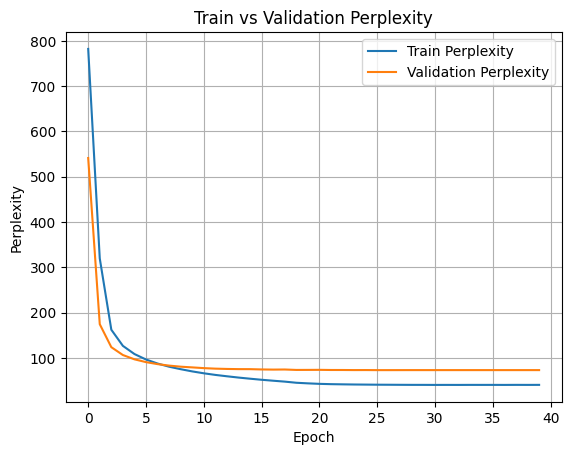

In [ ]:
import matplotlib.pyplot as plt

# Perplexity plot
plt.figure()
plt.plot(train_ppls, label="Train Perplexity")
plt.plot(valid_ppls, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Train vs Validation Perplexity")
plt.legend()
plt.grid(True)
plt.show()


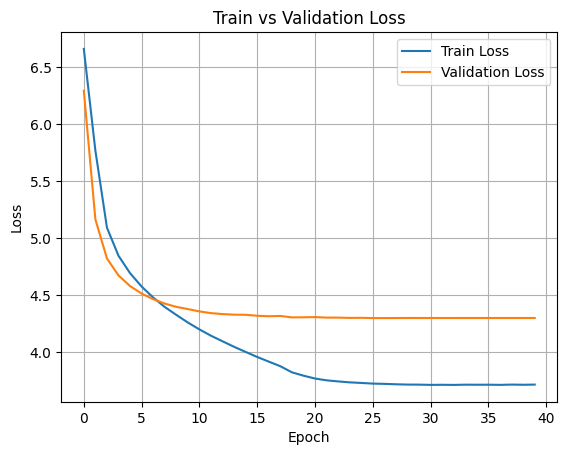

In [ ]:
# Loss plot
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## 6. Testing

In [34]:
model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'Test Perplexity: {math.exp(test_loss):.3f}')

Test Perplexity: 73.540


## 7. Real-world inference

Here we take the prompt, tokenize, encode and feed it into the model to get the predictions.  We then apply softmax while specifying that we want the output due to the last word in the sequence which represents the prediction for the next word.  We divide the logits by a temperature value to alter the model’s confidence by adjusting the softmax probability distribution.

Once we have the Softmax distribution, we randomly sample it to make our prediction on the next word. If we get <unk> then we give that another try.  Once we get <eos> we stop predicting.
    
We decode the prediction back to strings last lines.

In [35]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)

            #prediction: [batch size, seq len, vocab size]
            #prediction[:, -1]: [batch size, vocab size] #probability of last vocab

            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)
            prediction = torch.multinomial(probs, num_samples=1).item()

            while prediction == vocab['<unk>']: #if it is unk, we sample again
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['<eos>']:    #if it is eos, we stop
                break

            indices.append(prediction) #autoregressive, thus output becomes input

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [36]:
prompt = 'Harry Potter is '
max_seq_len = 30
seed = 0

#smaller the temperature, more diverse tokens but comes
#with a tradeoff of less-make-sense sentence
temperatures = [0.5, 0.7, 0.75, 0.8, 1.0]
for temperature in temperatures:
    generation = generate(prompt, max_seq_len, temperature, model, tokenizer,
                          vocab, device, seed)
    print(str(temperature)+'\n'+' '.join(generation)+'\n')

0.5
harry potter is the one who knew it would be an object of a giveaway . ” “but , ” said harry . “i know , i was doing , and i didn’t

0.7
harry potter is the one who knew the thing — ” “of course he had , ” said ron . “the portraits were confused . . . . ” “and i thought i

0.75
harry potter is the one who knew the thing — ” “of course he had , ” said ron . “the portraits were confused . . . . ” “and i thought i

0.8
harry potter is the one who knew the thing — ” “of course he had , ” said ron . “the portraits were confused . . . maybe you’re going to do with

1.0
harry potter is the one who knew the thief — i asked snape . . . ” it was nearly quite portraits but confused . “what are you doing ? ” the four

